# Mini Proxecto

## 1.Importaciones

In [75]:
import numpy as np
import pyzbar
import cv2 as cv2
import re
import os
import pytesseract
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode

## 2.Tratamiento de la imagen

### 2.1.Leemos la imagen

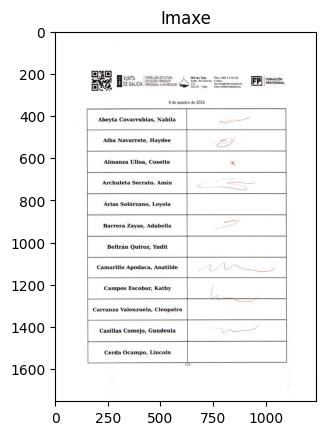

In [76]:
img = cv2.imread("Escaneo.jpg")
#img = cv2.imread("Escaneo0001.jpg")
plt.imshow(img)
plt.title('Imaxe')
plt.show()

### 2.2.Detectamos el QR

In [77]:
# Decodificamos el QR
decodificador_qr = decode(img)

# Mostramos la información que contiene
for i in decodificador_qr:
    contenido_qr =  i.data.decode('utf-8')
    print("Info:", contenido_qr)

    # El 1 indica que solo lo haga el split con el primero
    pagina, fecha = contenido_qr.split('-',1)

    # Imprimimos
    print('Nº página: ', pagina)
    print('Fecha: ', fecha)


Info: 1/3-2024-01-08
Nº página:  1/3
Fecha:  2024-01-08


### 2.3.Seleccionamos el rectángulo principal

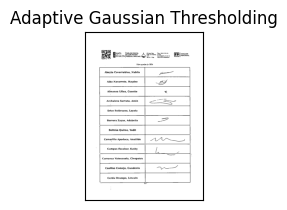

In [78]:
#Suavizamos la imagen convirtiendolo a una escala de grises y adaptamos el umbral

blurMedian = cv2.medianBlur(img,5)
blurMedian_gray = cv2.cvtColor(blurMedian, cv2.COLOR_BGR2GRAY)
umbral = cv2.adaptiveThreshold(blurMedian_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

plt.subplot(2,3,1),plt.imshow(umbral,'gray')
plt.title('Adaptive Gaussian Thresholding')
plt.xticks([]),plt.yticks([])
plt.show()

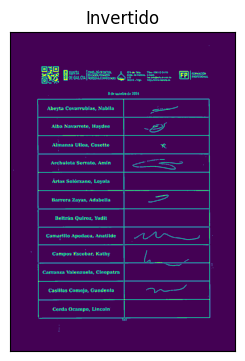

In [79]:
# Invertimos la imagen
invertido = cv2.bitwise_not(umbral)
plt.subplot(122),plt.imshow(invertido),plt.title('Invertido')
plt.xticks([]), plt.yticks([])
plt.show()

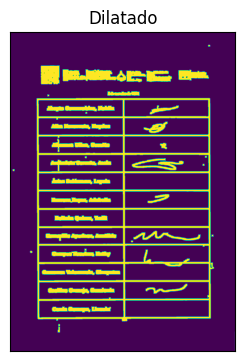

In [80]:
# Dilatamos el invertido

kernel = np.ones((5,5),np.uint8)
dilatacion = cv2.dilate(invertido,kernel,iterations = 2)
plt.subplot(122),plt.imshow(dilatacion),plt.title('Dilatado')
plt.xticks([]), plt.yticks([])
plt.show()

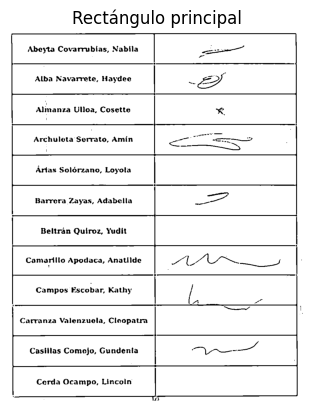

In [81]:
# Detectamos los contornos
contornos, jerarquia = cv2.findContours(dilatacion, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenamos la lista de contornos
contornos = sorted(contornos, key=cv2.contourArea, reverse=True)

# Seleccionamos el contorno más grande
contorno_mas_grande = contornos[0]

# Obtenemos las coordenadas del contorno
x, y, w, h = cv2.boundingRect(contorno_mas_grande)

# Recortamos según las coordenadas obtenidas antes
rect_principal = umbral[y:y+h, x:x+w]

# Mostramos el rectángulo principal
plt.imshow(rect_principal, cmap='gray')
plt.title('Rectángulo principal')
plt.axis('off')
plt.show()


### 2.4.Dividimos el rectángulo principal

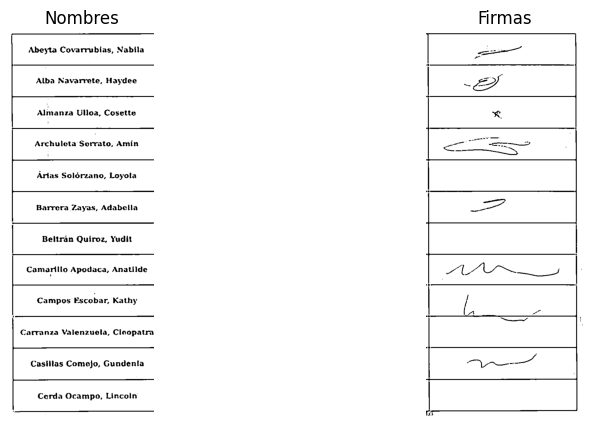

In [82]:
# Dividimos el rectángulo principal en dos partes
mitad_ancho = w // 2

# Recortamos la parte izquierda, la de los nombres
izquierda = rect_principal[:, :mitad_ancho - 30] # Ponemos -30 para evitar el borde y no nos de problemas a la hora de sacar los nombres

# Recortamos la parte de derecha, la de ls firmas
derecha = rect_principal[:, mitad_ancho -15:] # Y en este caso menos quince para que a la hora de detectar los contornos tampoco haya problemas

# Mostramos tanto los nombre como las firmas
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(izquierda, cmap='gray')
plt.title('Nombres')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(derecha, cmap='gray')
plt.title('Firmas')
plt.axis('off')

plt.show()

### 2.5.Obtenemos la lista de nombres

In [83]:
# Ruta del ejecutable
pytesseract.pytesseract.tesseract_cmd = r'/home/a23samuelan/miniconda3/envs/proba/bin/tesseract'

# Establecemos la variable de entorno TESSDATA_PREFIX
os.environ['TESSDATA_PREFIX'] = '/home/a23samuelan/miniconda3/envs/proba/share/tessdata'

# Obtenemos el texto de la izq
texto_izq = pytesseract.image_to_string(izquierda)

# Filtramos caracteres no deseados y dividimos por salto de línea
nombres = re.split(r'\n+', texto_izq)

# Limpiamos los nombres y eliminamos cadenas vacías
nombres = [re.sub(r'[^a-zA-Z, ]', '', nombre).strip() for nombre in nombres if nombre.strip()]

# Imprimimos
print("Nombres en la parte izquierda:", nombres)

Nombres en la parte izquierda: ['Abeyta Covarrubias, Nabila', 'Alba Navarrete, Haydeo', 'Alianza Ulloa, Cosette', 'Archulota Sorrato, Amin', 'Artas Solrzano, Loyola', 'Barrora Zayas, Adabella', 'Beltran Quiroz, Yudit', 'Camarillo Apodaca, Anatilde', 'Campos Escobar, Kathy', 'Carranza Valenzuela, Cloopatra', 'Casillas Comejo, Gundenta', 'Cerda Ocampo, Lincoln']


### 2.6.Obtenemos la lista booleana de firmas

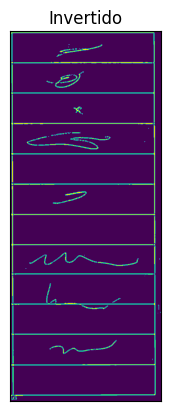

In [84]:
# Invertimos la imagen

invertido_der = cv2.bitwise_not(derecha)
plt.subplot(122),plt.imshow(invertido_der),plt.title('Invertido')
plt.xticks([]), plt.yticks([])
plt.show()

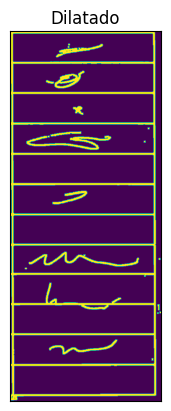

In [85]:
# Dilatamos el invertido

kernel = np.ones((5,5),np.uint8)
dilatacion_der = cv2.dilate(invertido_der,kernel,iterations = 1)
plt.subplot(122),plt.imshow(dilatacion_der),plt.title('Dilatado')
plt.xticks([]), plt.yticks([])
plt.show()

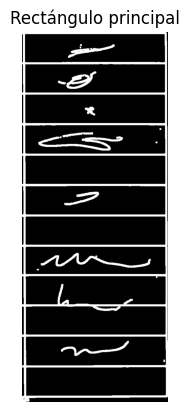

In [86]:
# Detectamos los contornos
contornos_der, jerarquia = cv2.findContours(dilatacion_der, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Ordenamos la lista de contornos
contornos_der = sorted(contornos_der, key=cv2.contourArea, reverse=True)

# Seleccionamos el contorno más grande
contorno_mas_grande_der = contornos_der[0]

# Obtenemos las coordenadas del contorno
x, y, w, h = cv2.boundingRect(contorno_mas_grande_der)

# Recortamos según las coordenadas obtenidas antes
rect_principal_der = dilatacion_der[y:y+h, x:x+w]

# Mostramos el rectángulo principal
plt.imshow(rect_principal_der, cmap='gray')
plt.title('Rectángulo principal')
plt.axis('off')
plt.show()

In [87]:
# Dividimos el contorno principal en 12 partes para separar cada firma
div_alto = h // 12

# Creamos una lista para guardar las firmas
firmas = []

# Creamos una lista para guardar si hay firma o no
lista_confirmcaion_firmas = []

# Recorremos 12 veces para almacenar las doce firma en la lista
for i in range(12):
    # Calculamos las coordenadas 
    inicio = i * div_alto 
    fin = (i + 1) * div_alto 
    
    # Recortamos cada firma
    firma = rect_principal_der[inicio:fin, :]

    # Añadimos a la lista
    firmas.append(firma)

# Recorremos las firmas
for i, firma in enumerate(firmas):
    
    # Definimos el tamaño del rectángulo interior
    rect_interior_x = firma.shape[1] // 6
    rect_interior_y = firma.shape[0] // 7
    rect_interior_width = firma.shape[1] * 2 // 3
    rect_interior_height = firma.shape[0] * 2 // 3

    # Recortamos la firma segun el tamaño del rectángulo interior
    region_interior = firma[rect_interior_y:rect_interior_y + rect_interior_height, 
                            rect_interior_x:rect_interior_x + rect_interior_width]

    # Miramos si hay contornos
    contours, _ = cv2.findContours(region_interior, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) > 0:
        lista_confirmcaion_firmas.append('Realizó la firma')
    else:
        lista_confirmcaion_firmas.append('No realizó la firma')

# Imprimimos
print(lista_confirmcaion_firmas)   




['Realizó la firma', 'Realizó la firma', 'Realizó la firma', 'Realizó la firma', 'No realizó la firma', 'Realizó la firma', 'No realizó la firma', 'Realizó la firma', 'Realizó la firma', 'No realizó la firma', 'Realizó la firma', 'No realizó la firma']


### 2.7.Salida esperada

In [88]:
# Creamos el diccionario con la salida esperada
firmo = dict(zip(nombres, lista_confirmcaion_firmas))

# Imprimimos el diccionario, fecha y página
print('Nº página: ', pagina)
print('Fecha: ', fecha)
print('Firmas: ',firmo)

Nº página:  1/3
Fecha:  2024-01-08
Firmas:  {'Abeyta Covarrubias, Nabila': 'Realizó la firma', 'Alba Navarrete, Haydeo': 'Realizó la firma', 'Alianza Ulloa, Cosette': 'Realizó la firma', 'Archulota Sorrato, Amin': 'Realizó la firma', 'Artas Solrzano, Loyola': 'No realizó la firma', 'Barrora Zayas, Adabella': 'Realizó la firma', 'Beltran Quiroz, Yudit': 'No realizó la firma', 'Camarillo Apodaca, Anatilde': 'Realizó la firma', 'Campos Escobar, Kathy': 'Realizó la firma', 'Carranza Valenzuela, Cloopatra': 'No realizó la firma', 'Casillas Comejo, Gundenta': 'Realizó la firma', 'Cerda Ocampo, Lincoln': 'No realizó la firma'}
